In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Extracting /home/CIFAR-10 Classifier Using CNN in PyTorch/data/cifar-10-python.tar.gz to /home/CIFAR-10 Classifier Using CNN in PyTorch/data/
Files already downloaded and verified


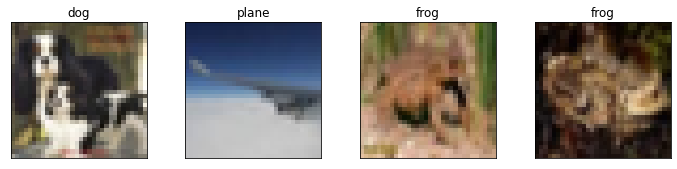

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    image = image / 2 + 0.5
    image = image.numpy()
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
import os

model_directory_path = '/home/CIFAR-10 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2): 
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:   
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model parameters to disk.')


[1,  2000] loss: 2.186
[1,  4000] loss: 1.869
[1,  6000] loss: 1.680
[1,  8000] loss: 1.605
[1, 10000] loss: 1.518
[1, 12000] loss: 1.484
[2,  2000] loss: 1.403
[2,  4000] loss: 1.378
[2,  6000] loss: 1.353
[2,  8000] loss: 1.343
[2, 10000] loss: 1.326
[2, 12000] loss: 1.314
Finished Training.
Saved model parameters to disk.


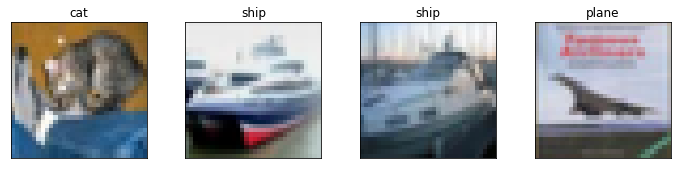

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


In [15]:
outputs = net(images)


In [16]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)


tensor([[1.4483e-02, 3.7366e-03, 7.6948e-02, 6.5063e-01, 5.0632e-03, 1.7403e-01,
         2.6409e-02, 8.9847e-03, 3.5642e-02, 4.0735e-03],
        [2.1898e-01, 2.1986e-01, 1.8466e-02, 1.8073e-04, 3.0696e-04, 9.8754e-05,
         4.0852e-05, 3.7616e-05, 5.3108e-01, 1.0951e-02],
        [1.7933e-01, 1.9558e-01, 8.5136e-02, 1.1040e-02, 7.3589e-03, 7.1355e-03,
         3.9383e-03, 4.0554e-03, 4.1552e-01, 9.0910e-02],
        [2.9806e-01, 8.5115e-02, 2.2738e-02, 1.8686e-03, 5.4929e-03, 5.7711e-04,
         7.6902e-04, 5.3956e-04, 5.5747e-01, 2.7373e-02]],
       grad_fn=<SoftmaxBackward>)


In [17]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))


Model accuracy on 10000 test images: 54.26%


In [18]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))


Category   - Accuracy
plane      - 56.5
car        - 66.0
bird       - 41.1
cat        - 43.8
deer       - 32.4
dog        - 47.5
frog       - 73.5
horse      - 52.7
ship       - 67.0
truck      - 62.1


In [19]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()


actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           565       27        117       35        25        11        25        4         148       43        
                0.565     0.027     0.117     0.035     0.025     0.011     0.025     0.004     0.148     0.043     
car             31        660       34        13        3         13        40        3         55        148       
                0.031     0.66      0.034     0.013     0.003     0.013     0.04      0.003     0.055     0.148     
bird            53        7         411       112       81        122       142       35        24        13        
                0.053     0.007     0.411     0.112     0.081     0.122     0.142     0.035     0.024     0.013     
cat             20        16        65        438       35        194       150       27        20        35        
                0.02      0.016     0.065     0.438     0.035   

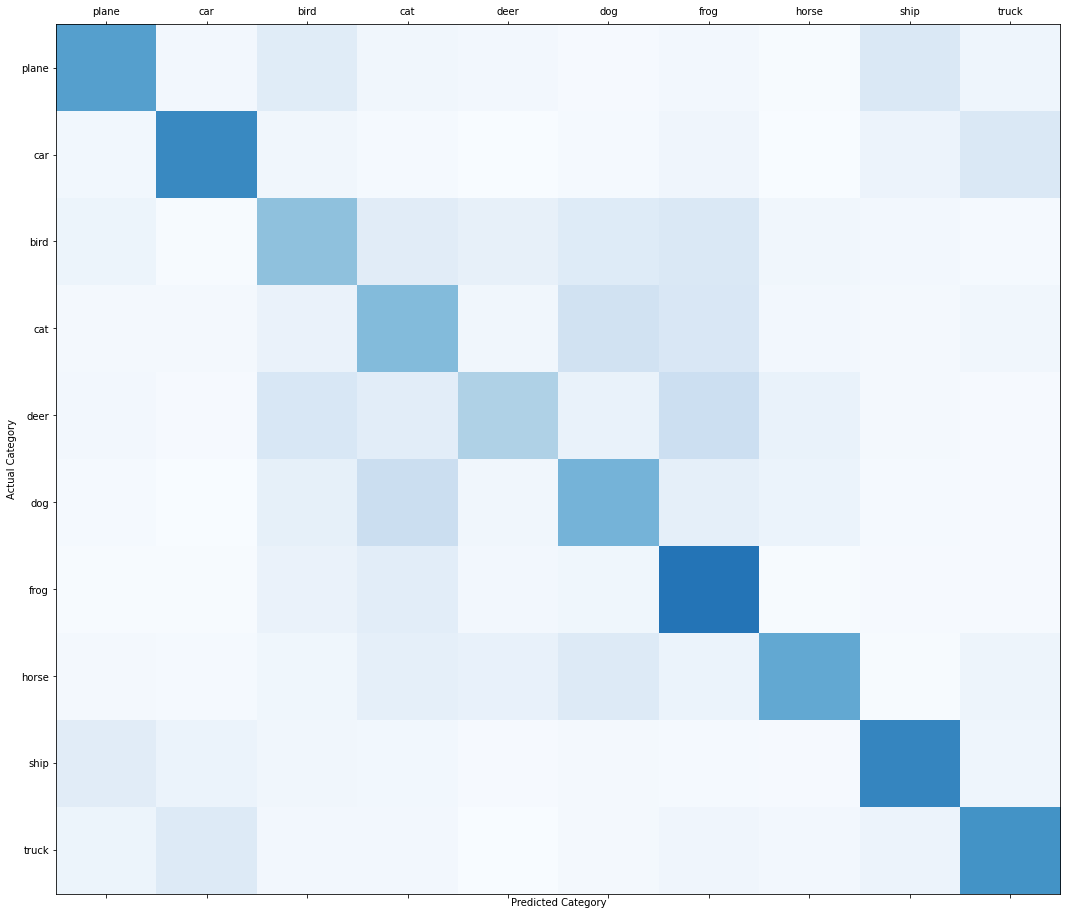

In [21]:
fig, ax = plt.subplots(1,1,figsize=(18,16))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()
